# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2020-09-25 05:26:31,524 INFO    : root         : Using LISA logging configuration:
2020-09-25 05:26:31,525 INFO    : root         :   /home/ubuntu/Android/lisa_old/logging.conf


In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2020-09-25 05:26:31,784 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2020-09-25 05:26:31,798 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
    'setSurface' : {
        'SMARK' : {'context' : 'setSurface', 'type' : 'B'}, 
        'EMARK' : {'context' : 'setSurface', 'type' : 'E'},
    },
}

In [7]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [8]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnMTRJR1pVUC9hcXVlZHVjdHMnLCBsYXlvdXQ9TGF5b3V0KHdpZHRoPXUnMjAwJScpLCBzdHlsZT1EZXPigKY=


## Run cells

Please select over systrace files and press the run button to execute below cells.

In [11]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [12]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-2] + "_" + file_path[-1]]

if len(filelist) == 0:
    raise  ValueError('Please select some groups of systrace in the over cell.')

Please select some systraces to analysis.

## Read Files

In [13]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [14]:
group1.run()
group2.run()

Parsing 0EBF5TC3_QOS_200304_200304_105505_setting.html - 120730 lines are Ok
Parsing 0EBF5TC3_QOS_200304_200304_145413_setting.html - 119141 lines are Ok
Parsing 0EBF5TC3_QOS_200304_200304_135441_setting.html - 119916 lines are Ok
Parsing 0FBF5TA2_QOS_200117_200117_181431_setting.html - 103676 lines are Ok
Parsing 0FBF5TA2_QOS_200117_200117_202655_setting.html - 108046 lines are Ok
Parsing 0FBF5TA2_QOS_200117_200117_192043_setting.html - 134649 lines are Ok


## Analysis

### The timing of marking data

The operation times of each trace_mark_filters.

In [15]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
12992.0,NaN,NaN,NaN,88.636,NaN,11.287,NaN,NaN
1545.0,NaN,113.566,5.793,132.195,189.892,14.088,62.392,NaN
2124.0,0.317,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2066.0,NaN,2.761,3.415,NaN,NaN,NaN,NaN,NaN
12815.0,0.013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1265.0,NaN,1.035,42.429,NaN,NaN,NaN,NaN,NaN
1234.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,708.181
1593.0,NaN,16.795,0.359,NaN,NaN,NaN,NaN,NaN
3162.0,6.429,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
2049.0,NaN,1.644,3.619,NaN,NaN,NaN,NaN,NaN
1540.0,NaN,129.593,4.597,123.400,181.696,15.178,70.411,NaN
13057.0,20.807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1580.0,NaN,15.935,0.515,NaN,NaN,NaN,NaN,NaN
2093.0,0.330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1262.0,NaN,2.001,1.165,NaN,NaN,NaN,NaN,NaN
13069.0,NaN,NaN,NaN,91.526,NaN,9.764,NaN,NaN
12913.0,0.015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3090.0,5.330,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1539.0,NaN,127.725,6.689,115.923,183.755,69.231,68.476,NaN
13159.0,NaN,NaN,NaN,92.734,NaN,11.195,NaN,NaN
2124.0,0.447,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3114.0,5.541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1579.0,NaN,17.945,0.366,NaN,NaN,NaN,NaN,NaN
1260.0,NaN,0.927,50.073,NaN,NaN,NaN,NaN,NaN
2061.0,NaN,2.245,2.207,NaN,NaN,NaN,NaN,NaN
1261.0,NaN,1.661,1.464,NaN,NaN,NaN,NaN,NaN
1233.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735.318


In [16]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
5408.0,NaN,13.237,0.292,NaN,NaN,NaN,NaN,NaN
17285.0,NaN,147.459,13.843,83.298,140.861,49.919,58.271,NaN
5030.0,NaN,6.096,1.568,NaN,NaN,NaN,NaN,NaN
4970.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,628.38
5814.0,0.467,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6961.0,2.729,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5718.0,NaN,2.469,2.091,NaN,NaN,NaN,NaN,NaN
17340.0,NaN,NaN,NaN,97.864,NaN,14.879,NaN,NaN
17322.0,NaN,NaN,NaN,109.001,NaN,12.753,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
16801.0,21.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5764.0,NaN,2.493,5.204,NaN,NaN,NaN,NaN,NaN
5414.0,NaN,18.366,0.488,NaN,NaN,NaN,NaN,NaN
7015.0,3.509,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16776.0,NaN,143.124,1.942,106.229,146.183,13.270,56.291,NaN
16812.0,NaN,NaN,NaN,106.791,NaN,11.794,NaN,NaN
4972.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,584.451
5037.0,NaN,11.716,1.467,NaN,NaN,NaN,NaN,NaN
5038.0,NaN,1.589,1.706,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
5410.0,NaN,15.969,0.502,NaN,NaN,NaN,NaN,NaN
16835.0,19.970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16951.0,NaN,NaN,NaN,177.260,NaN,23.443,NaN,NaN
5034.0,NaN,0.924,26.976,NaN,NaN,NaN,NaN,NaN
5035.0,NaN,1.761,1.541,NaN,NaN,NaN,NaN,NaN
5741.0,NaN,2.372,1.444,NaN,NaN,NaN,NaN,NaN
7053.0,3.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16866.0,NaN,NaN,NaN,105.735,NaN,10.128,NaN,NaN
4979.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,601.789


### Launching Time(AVERAGE)

This section is showing the app launching time.

In [17]:
list_of_df = group1.get_marking_time()
sum_df1 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

try :
    sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1) * 1000
    sum_df1.loc['mean'] = sum_df1.mean()
except:
    print("No launching time")
    
list_of_df = group2.get_marking_time()
sum_df2 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching

try :
    sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1) * 1000
    sum_df2.loc['mean'] = sum_df2.mean()
except:
    print("No launching time")

No launching time
No launching time


In [18]:
display(pd.concat([sum_df1, sum_df2], keys=[group1.title, group2.title], sort=False))

launching
                                                pid               
0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting 1234.0  708.181000
                                                1235.0  673.104000
                                                1233.0  735.318000
                                                mean    705.534333
0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting 4970.0  628.380000
                                                4972.0  584.451000
                                                4979.0  601.789000
                                                mean    604.873333

### Process Time(AVERAGE)

Process time is from start to end timing within systrace tag of binadApplication / activityStart / ActivityThreadMain / ActivityResume.
 - time : total sum of time of running / runnable / sleeping / uninterruptible sleep.
 - running / runnable / sleeping / uninterruptible sleep : Process stat of cores.
 - setSurface : Just test and check the length of setSurface's tags.
 - launching : Sum of each tags, bindApplication, activityStart, ActivityThreadMain, activityResume, and Choreographer.

In [19]:
df1 = group1.get(systrace_parser.process_state()) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(systrace_parser.process_state()) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [20]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

setSurface  \
0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting time                                0   
                                                RUNNING                             0   
                                                RUNNABLE                            0   
                                                SLEEPING                            0   
                                                UNINTERUPTIBLE_SLEEP                0   
                                                UNINTERUPTIBLE_SLEEP(I/O)           0   
0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting time                                0   
                                                RUNNING                             0   
                                                RUNNABLE                            0   
                                                SLEEPING                            0   
                                                UNINTERUPTIBLE_SLEEP                0   
                                                UNINTERUPTIBLE_SLEEP(I/O)           0   
DIFF                                            time                                0   
                                                RUNNING                             0   
                                                RUNNABLE                            0   
                                                SLEEPING                            0   
                                                UNINTERUPTIBLE_SLEEP                0   
                                                UNINTERUPTIBLE_SLEEP(I/O)           0   

                                                                           Choreographer #0  \
0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting time                                123.628   
                                                RUNNING                              55.175   
                                                RUNNABLE                              1.868   
                                                SLEEPING                             64.320   
                                                UNINTERUPTIBLE_SLEEP                  0.029   
                                                UNINTERUPTIBLE_SLEEP(I/O)             2.236   
0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting time                                142.361   
                                                RUNNING                              71.787   
                                                RUNNABLE                              0.662   
                                                SLEEPING                             65.941   
                                                UNINTERUPTIBLE_SLEEP                  1.436   
                                                UNINTERUPTIBLE_SLEEP(I/O)             2.536   
DIFF                                            time                                -18.733   
                                                RUNNING                             -16.612   
                                                RUNNABLE                              1.206   
                                                SLEEPING                             -1.621   
                                                UNINTERUPTIBLE_SLEEP                 -1.407   
                                                UNINTERUPTIBLE_SLEEP(I/O)            -0.300   

                                                                           Choreographer #1  \
0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting time                                  5.693   
                                                RUNNING                               3.056   
                                                RUNNABLE                              0.537   
                                                SLEEPING                              2.099   
                                                UNINTERUPTIBLE_SLEEP                  0.000   
       

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting,time,0,123.628,5.693,123.839,185.114,32.832,67.093,0
0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting,time,0,142.361,5.956,99.254,143.905,27.255,60.615,0
DIFF,time,0,-18.733,-0.263,24.585,41.209,5.577,6.478,0


### Processing time of setSurface

In [21]:
def ProcessingTime(group, index):
    result = dict()
    list_of_df = group.get_marking_time()
    sum = 0
    count = 0
    for df in list_of_df:
        df = df['setSurface'].fillna(0)
        max_value = df.max() * 1000
        sum += max_value
        count += 1
        result[count] = [max_value]
    #print("SUM : {}, AVG : {}".format(sum, sum/count))
    result['avg'] = [sum/count]
    
    df = DataFrame.from_dict(result)
    df.index = [group.title]
    return df

In [22]:
df1 = ProcessingTime(group1, 'setSurface')
df2 = ProcessingTime(group2, 'setSurface')
display(pd.concat([df1, df2]))

,1,2,3,avg
0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting,20.008,20.807,20.133,20.316000
0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting,25.531,21.500,19.970,22.333667


### Uninterruptible Sleep

The count of uninterruptible sleep within each tags.

In [23]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

In [24]:
print(group1.title)
display(df1)

0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
uninter_reason//SyS_mprotect+0x88/0x208,0.333333,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//__fdget_pos+0x3c/0x4c,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//__fdget_pos+0x40/0x50,0.000000,0.0,0.000000,0.000000,0.0,0.333333
uninter_reason//_synchronize_rcu_expedited+0x2c0/0x364,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//do_page_fault+0x2a8/0x424,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//do_page_fault+0x2c8/0x444,0.000000,0.0,0.000000,0.333333,0.0,0.000000
uninter_reason//vm_mmap_pgoff+0x74/0x104,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//vm_munmap+0x44/0xa0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason_io//__lock_page+0x168/0x1dc,1.666667,0.0,8.000000,68.333333,0.0,14.333333
uninter_reason_io//__lock_page_killable+0x168/0x20c,0.000000,0.0,2.666667,1.333333,0.0,0.000000


In [25]:
print(group2.title)
display(df2)

0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
uninter_reason//SyS_mprotect+0x88/0x208,1.000000,0.0,0.000000,1.333333,0.0,0.000000
uninter_reason//__fdget_pos+0x3c/0x4c,0.666667,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//__fdget_pos+0x40/0x50,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//_synchronize_rcu_expedited+0x2c0/0x364,0.000000,0.0,0.000000,0.000000,0.0,0.333333
uninter_reason//do_page_fault+0x2a8/0x424,7.333333,0.0,1.666667,11.000000,0.0,0.333333
uninter_reason//do_page_fault+0x2c8/0x444,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//vm_mmap_pgoff+0x74/0x104,0.666667,0.0,0.333333,0.666667,0.0,0.333333
uninter_reason//vm_munmap+0x44/0xa0,0.000000,0.0,0.000000,0.666667,0.0,0.000000
uninter_reason_io//__lock_page+0x168/0x1dc,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason_io//__lock_page_killable+0x168/0x20c,0.000000,0.0,0.000000,0.000000,0.0,0.000000


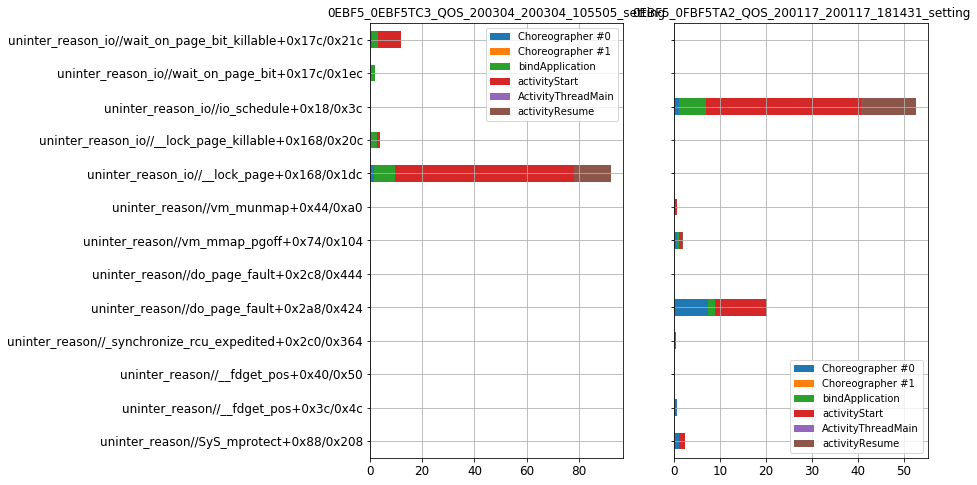

In [26]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)
df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

The number of count in each reason of uninterruptible sleep.

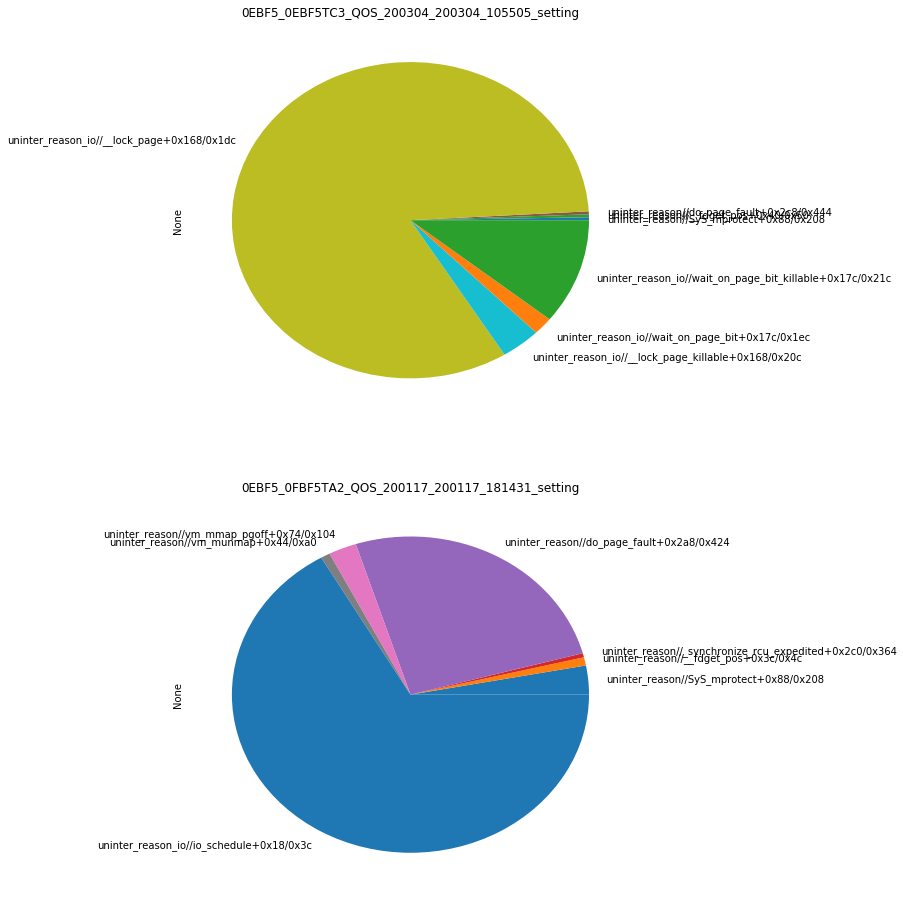

In [27]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

### Number of Running Cores(SUM)

The number of counting running cores when entering an app.

In [28]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)

In [29]:
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

Choreographer #0  \
0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting core0                 0   
                                                core1                 1   
                                                core2                 1   
                                                core3                 0   
                                                core4                 0   
                                                core5                 0   
                                                core6                30   
                                                core7                56   
0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting core0                 0   
                                                core1                 1   
                                                core2                 1   
                                                core3                 3   
                                                core4                11   
                                                core5                37   
                                                core6                 7   
                                                core7                17   

                                                       Choreographer #1  \
0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting core0                 0   
                                                core1                 0   
                                                core2                 0   
                                                core3                 0   
                                                core4                 0   
                                                core5                 0   
                                                core6                 3   
                                                core7                 9   
0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting core0                 1   
                                                core1                 0   
                                                core2                 1   
                                                core3                 0   
                                                core4                 0   
                                                core5                 0   
                                                core6                 0   
                                                core7                 4   

                                                       bindApplication  \
0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting core0                2   
                                                core1                6   
                                                core2                1   
                                                core3                4   
                                                core4                2   
                                                core5                3   
                                                core6               81   
                                                core7              145   
0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting core0                2   
                                                core1                1   
                                                core2                0   
                                                core3                1   
                                                core4               33   
                                                core5               29   
                                                core6               34   
                                                core7               10   

                                                       activityStart  \
0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting core0              7   
                                                core1              3   
                            

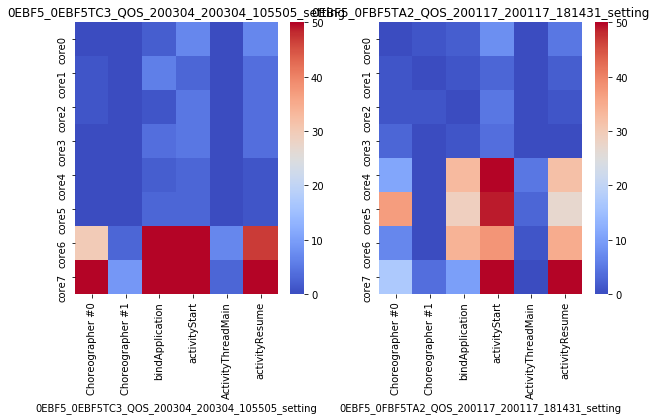

In [30]:
plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [31]:
print(group1.title)
for parser in group1.parsers_of_testing:
    display(parser.get(group1.cores()))

0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,1,1,0,3,NaN
core1,NaN,0,0,2,0,0,1,NaN
core2,NaN,0,0,0,2,0,0,NaN
core3,NaN,0,0,1,0,0,0,NaN
core4,NaN,0,0,2,1,0,0,NaN
core5,NaN,0,0,1,1,0,0,NaN
core6,NaN,6,3,36,49,0,4,NaN
core7,NaN,23,0,42,76,3,45,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,1,3,0,2,NaN
core1,NaN,1,0,3,0,0,1,NaN
core2,NaN,1,0,1,0,0,3,NaN
core3,NaN,0,0,0,2,0,3,NaN
core4,NaN,0,0,0,2,0,0,NaN
core5,NaN,0,0,0,2,0,0,NaN
core6,NaN,13,0,33,68,3,17,NaN
core7,NaN,17,3,46,51,0,33,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,0,3,0,2,NaN
core1,NaN,0,0,1,3,0,2,NaN
core2,NaN,0,0,0,3,0,1,NaN
core3,NaN,0,0,3,3,0,1,NaN
core4,NaN,0,0,0,0,0,1,NaN
core5,NaN,0,0,2,0,0,1,NaN
core6,NaN,11,0,12,54,4,26,NaN
core7,NaN,16,6,57,72,0,25,NaN


In [32]:
print(group2.title)
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,0,4,0,0,NaN
core1,NaN,0,0,0,0,0,2,NaN
core2,NaN,1,1,0,2,0,1,NaN
core3,NaN,0,0,1,1,0,0,NaN
core4,NaN,2,0,6,29,0,8,NaN
core5,NaN,8,0,2,16,3,8,NaN
core6,NaN,3,0,10,15,0,13,NaN
core7,NaN,11,2,8,17,0,23,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,1,0,0,2,NaN
core1,NaN,0,0,1,3,0,0,NaN
core2,NaN,0,0,0,1,0,0,NaN
core3,NaN,3,0,0,0,0,0,NaN
core4,NaN,7,0,13,30,3,13,NaN
core5,NaN,15,0,17,14,0,5,NaN
core6,NaN,1,0,11,11,0,13,NaN
core7,NaN,5,1,2,25,0,19,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,1,1,4,0,3,NaN
core1,NaN,1,0,0,0,0,0,NaN
core2,NaN,0,0,0,2,0,0,NaN
core3,NaN,0,0,0,3,0,0,NaN
core4,NaN,2,0,14,35,2,11,NaN
core5,NaN,14,0,10,19,0,14,NaN
core6,NaN,3,0,13,12,1,9,NaN
core7,NaN,1,1,0,14,0,15,NaN


In [33]:
from systrace_parser import TAG_CORE_IDLE
def GetCoreStats(group):
    for parser in group.parsers_of_testing:
        rawdata = parser.get_rawdata('stat_core')
        index_key_list = list()
        df_list = list()
        
        for index_key in rawdata.keys():
            #print(index_key)
            index_key_list.append(index_key)

            core_state_dict = dict()
            for i in range(8):
                core_state_dict[i] = list()
            core_state_dict['selected'] = list()
            core_state_dict['time'] = list()

            for core_state in rawdata[index_key]:
                for i in range(8):
                    core_state_dict[i].append(core_state.get(i, TAG_CORE_IDLE))
                core_state_dict['selected'].append(core_state.get('selected', -1))
                core_state_dict['time'].append(core_state.get('time', -1))
            #display(DataFrame.from_dict(core_state_dict))
            df_list.append(DataFrame.from_dict(core_state_dict))

    return pd.concat(df_list, keys=index_key_list, sort=False).sort_values(by=['time'])
pd.set_option('display.max_rows', 500)

In [34]:
print(group1.title)
display(GetCoreStats(group1))

0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting


0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0    I  I  R  I  I  I  V  I         6  331.352155
                   1    I  I  I  I  R  I  V  I         6  331.353734
                   2    I  R  I  I  I  I  V  R         6  331.354393
                   3    I  I  I  V  I  I  R  R         3  331.419727
bindApplication    0    I  I  I  V  I  I  I  I         3  331.421409
                   1    I  I  I  V  I  I  I  R         3  331.421773
                   2    R  I  R  I  I  V  I  I         5  331.422806
                   3    I  I  I  I  I  V  I  I         5  331.423297
                   4    R  R  I  I  I  I  I  V         7  331.429425
                   5    R  R  I  I  R  R  I  V         7  331.429820
                   6    R  R  R  I  R  I  I  V         7  331.435320
                   7    R  R  I  I  I  R  R  V         7  331.436094
                   8    I  R  R  I  I  I  R  V         7  331.436401
                   9    R  I  R  I  I  I  R  V         7  331.439969
                   10   I  V  I  I  R  I  R  I         1  331.448091
                   11   I  R  R  I  R  I  R  V         7  331.448223
                   12   I  I  I  I  R  R  I  V         7  331.451300
                   13   R  I  I  I  R  R  I  V         7  331.457286
                   14   R  R  I  I  I  I  I  V         7  331.457819
                   15   I  I  R  I  R  I  I  V         7  331.459617
                   16   I  I  I  I  I  I  I  V         7  331.461299
                   17   I  R  I  I  R  I  I  V         7  331.463194
                   18   I  I  I  I  R  I  I  V         7  331.463631
                   19   R  I  I  I  I  I  I  V         7  331.469880
                   20   R  R  I  R  R  I  I  V         7  331.470738
                   21   I  R  R  I  I  R  I  V         7  331.472566
                   22   R  I  I  R  I  I  I  V         7  331.473105
                   23   I  I  R  I  R  I  I  V         7  331.476076
                   24   I  I  R  I  R  I  R  V         7  331.477193
                   25   R  R  I  I  I  I  I  V         7  331.479269
                   26   I  I  I  I  I  I  R  V         7  331.479837
                   27   I  I  R  I  I  I  I  V         7  331.480557
                   28   I  I  I  I  R  I  I  V         7  331.480890
                   29   I  I  I  I  R  I  I  V         7  331.481278
                   30   I  I  I  I  R  I  I  V         7  331.482255
                   31   I  R  I  I  R  I  I  V         7  331.483431
                   32   R  I  R  I  I  I  I  V         7  331.483610
                   33   I  I  I  R  R  I  I  V         7  331.485213
                   34   R  I  I  R  R  I  I  V         7  331.485389
                   35   R  I  I  R  R  I  I  V         7  331.485709
                   36   R  I  I  R  R  R  I  V         7  331.486689
                   37   R  I  I  R  R  I  I  V         7  331.486973
                   38   R  I  I  R  R  I  I  V         7  331.487119
                   39   R  I  I  R  R  I  I  V         7  331.487393
                   40   R  I  R  I  R  I  I  V         7  331.487582
                   41   I  R  R  I  I  I  R  V         7  331.488067
                   42   I  R  R  I  I  I  R  V         7  331.488100
                   43   R  I  R  R  I  I  R  V         7  331.488405
                   44   R  R  I  R  I  R  I  V         7  331.489411
                   45   R  R  I  R  I  R  I  V         7  331.489940
                   46   R  I  I  I  I  R  V  R         6  331.492437
                   47   R  R  I  I  I  I  V  I         6  331.493535
                   48   R  R  I  I  I  R  V  I         6  331.494052
                   49   I  I  I  I  I  I  V  R         6  331.499015
                   50   I  I  I  I  I  I  I  V         7  331.499432
                   51   I  I  I  I  I  I  V  I         6  331.499486
                   52   I  I  R  I  R  R  V  I         6  331.501049
                   53 

In [35]:
print(group2.title)
display(GetCoreStats(group2))

0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting


0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0   I  I  R  I  V  I  I  I         4  340.122968
                   1   I  I  R  I  R  R  V  I         6  340.124183
                   2   R  R  I  I  R  R  V  I         6  340.139694
bindApplication    0   R  R  I  I  R  V  I  I         5  340.141316
                   1   R  R  I  I  R  V  I  R         5  340.141555
                   2   R  R  R  I  R  V  I  I         5  340.142782
                   3   I  R  R  I  R  V  I  I         5  340.143120
                   4   V  I  I  R  I  I  R  I         0  340.149280
                   5   I  R  I  R  V  I  R  I         4  340.150400
                   6   I  R  I  I  V  I  I  I         4  340.151588
                   7   I  R  I  I  V  I  I  I         4  340.152447
                   8   I  R  I  I  V  I  I  I         4  340.152694
                   9   R  I  I  I  V  I  I  I         4  340.153490
                   10  I  I  I  R  V  I  R  I         4  340.156072
                   11  I  I  I  I  V  I  R  I         4  340.158032
                   12  R  I  I  I  V  I  R  I         4  340.158694
                   13  I  I  I  I  V  I  R  I         4  340.162191
                   14  I  I  I  I  V  I  R  I         4  340.162365
                   15  I  I  I  I  V  I  R  I         4  340.163082
                   16  I  I  I  I  V  I  I  I         4  340.163619
                   17  I  I  I  I  V  I  R  I         4  340.167201
                   18  I  I  R  I  R  I  V  I         6  340.167382
                   19  I  I  I  R  R  I  V  I         6  340.168101
                   20  I  I  I  I  R  I  V  I         6  340.168484
                   21  R  I  I  I  R  I  V  I         6  340.168519
                   22  I  I  I  I  R  I  V  I         6  340.172449
                   23  R  R  I  R  R  I  V  I         6  340.182583
                   24  R  R  I  I  R  I  V  R         6  340.187064
                   25  R  R  I  I  R  I  V  I         6  340.187672
                   26  I  I  R  I  I  I  V  R         6  340.190805
                   27  I  R  R  I  I  I  V  R         6  340.192646
                   28  I  I  I  I  R  V  I  R         5  340.201203
                   29  I  I  I  I  R  R  V  R         6  340.201702
                   30  I  R  I  I  I  V  R  R         5  340.212633
                   31  I  R  I  R  R  V  R  R         5  340.213314
                   32  I  I  I  I  V  I  I  R         4  340.221819
                   33  I  R  I  I  R  V  I  R         5  340.222181
                   34  R  I  I  I  R  V  R  R         5  340.228187
                   35  I  R  I  I  R  V  R  I         5  340.235977
                   36  I  I  I  R  R  R  V  R         6  340.244766
                   37  R  I  R  R  V  R  R  I         4  340.248486
activityStart      0   R  R  I  I  R  R  V  I         6  340.249845
                   1   V  R  I  I  R  R  I  R         0  340.251933
                   2   R  R  I  I  V  R  I  R         4  340.252135
                   3   R  I  I  I  V  R  R  R         4  340.253476
                   4   R  I  R  I  V  I  R  R         4  340.253840
                   5   R  I  I  I  V  R  R  I         4  340.254368
                   6   R  I  I  I  V  R  R  R         4  340.254414
                   7   R  I  I  I  V  R  I  R         4  340.254465
                   8   R  I  I  I  R  R  V  R         6  340.254499
                   9   I  R  I  I  V  R  R  I         4  340.266093
                   10  I  I  I  R  V  R  R  R         4  340.266302
                   11  I  I  I  R  V  I  R  R         4  340.266333
                   12  I  I  I  R  V  I  R  R         4  340.266346
                   13  R  I  I  R  V  R  R  R         4  340.266458
                   14  R  R  V  I  I  R  R  R         2  340.266902
                   15  R  R  R  I  R  I  R  V         7  340.267082
                   16  I  R  I  I  V  R  R  I         4  340.269109
           

### Cpu Frequency

The graph to show a min lock status of core frequency.

In [36]:
from systrace_parser import CPU_FREQUENCY_LIMITS
def DrawCorrectedData(group, tyep_filter, data_label, func):
    prevalue = dict()
    list_of_df_for_start = group.get_marking_time(dtype='start')
    list_of_df_for_end = group.get_marking_time(dtype='end')
    idx = 0

    for item in group.get(tyep_filter, func='array'):
        df = DataFrame(item, columns=['cpu_id', 'time', data_label])
        df = df.apply(pd.to_numeric)
        
        ### to darw launcging time ++
        min_freq = df[data_label].min()
        prevalue['launching'] = min_freq
        
        if len(list_of_df_for_start) > idx:
            launching_time = list_of_df_for_start[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time, 
                           data_label : ((min_freq + 1) * 2)}, ignore_index=True) 
        if len(list_of_df_for_end) > idx:
            launching_time = list_of_df_for_end[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time,
                           data_label : min_freq}, ignore_index=True)
        ### to darw launcging time --
        
        if func != 0:
            df = func(df)
            
        length = len(df.index)
            
        for i in range(length):
            #display(df.iloc[i])
            if df.iloc[i]['cpu_id'] in prevalue.keys():
                df = df.append({'cpu_id' : df.iloc[i]['cpu_id'], 
                           'time' : (df.iloc[i]['time'] - 0.000001), 
                           data_label : prevalue[df.iloc[i]['cpu_id']]}, ignore_index=True) 
                #display(df.iloc[i])
            prevalue[df.iloc[i]['cpu_id']] = df.iloc[i][data_label]
        
        idx += 1
        df.index = df['time']
        df = df.sort_index()
        df.groupby(['cpu_id'])[data_label].plot(legend=True, figsize=(15,4))
        plt.show()

0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting


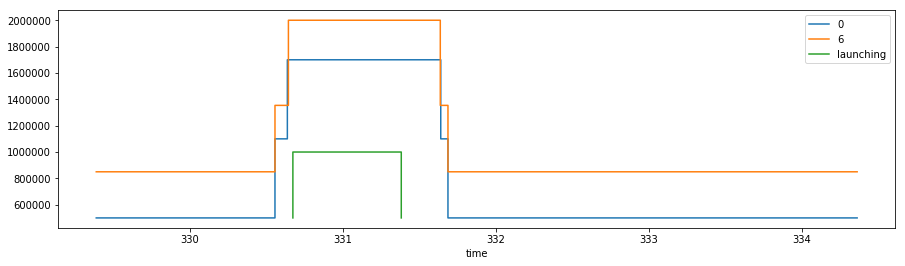

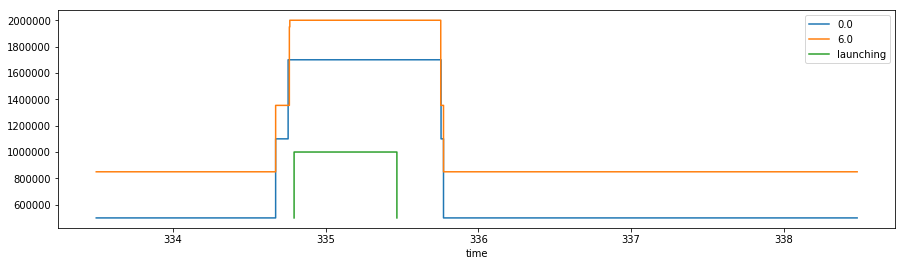

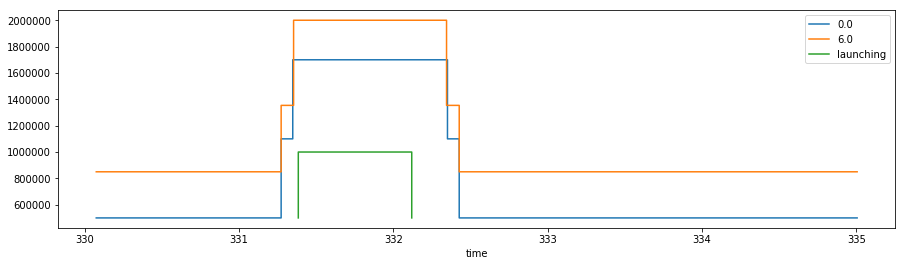

In [37]:
print(group1.title)
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

0EBF5_0FBF5TA2_QOS_200117_200117_181416_note
ERROR!!!   - parser_range::get() - columns has no the item
           - item : cpu_frequency_limits:
           - result_cores.keys() : ['setSurface', 'Choreographer #0', 'Choreographer #1', 'bindApplication', 'activityStart', 'ActivityThreadMain', 'activityResume', 'launching']
ERROR!!!   - parser_range::get() - columns has no the item
           - item : cpu_frequency_limits:
           - result_cores.keys() : ['setSurface', 'Choreographer #0', 'Choreographer #1', 'bindApplication', 'activityStart', 'ActivityThreadMain', 'activityResume', 'launching']
ERROR!!!   - parser_range::get() - columns has no the item
           - item : cpu_frequency_limits:
           - result_cores.keys() : ['setSurface', 'Choreographer #0', 'Choreographer #1', 'bindApplication', 'activityStart', 'ActivityThreadMain', 'activityResume', 'launching']


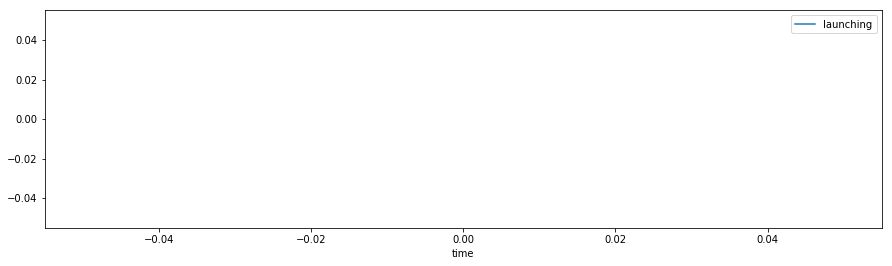

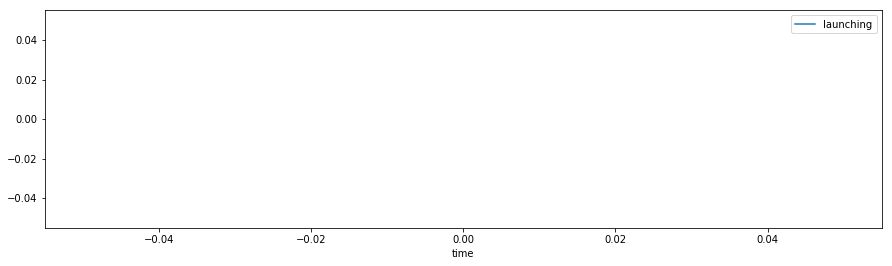

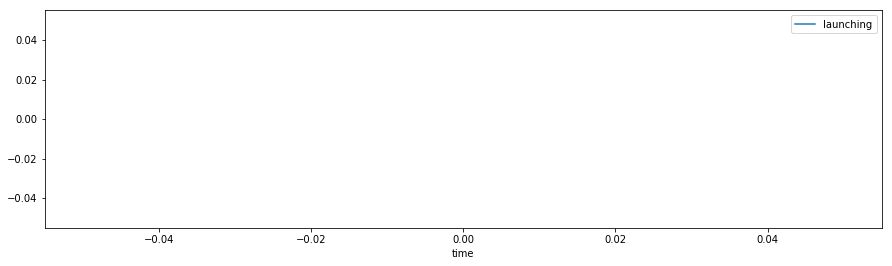

In [38]:
print(group2.title)
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Cpu Idle

The graph to show a min lock status of core Idle.

In [39]:
from systrace_parser import CPU_IDLE
def PreprocessingForCPUIDLE(df):
    try :
        df_launching = df[df.cpu_id == 'launching']
    except :
        df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

        df.loc[df.state >= 4294967295, 'state'] = -1
        df['state'] = df['state'] + 1
        
        return df

    df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

    df.loc[df.state >= 4294967295, 'state'] = -1
    df['state'] = df['state'] + 1
    
    df = df[df.time >= (df_launching['time'].iloc[0] - 0.1)]
    df = df[df.time <= (df_launching['time'].iloc[1] + 0.1)]
    
    df = pd.concat([df, df_launching])
    return df

0EBF5_0EBF5TC3_QOS_200304_200304_135427_note


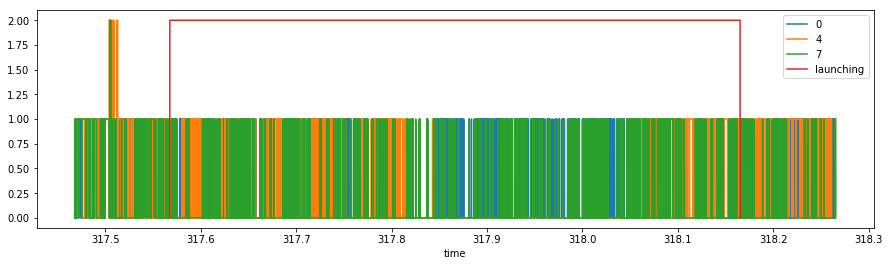

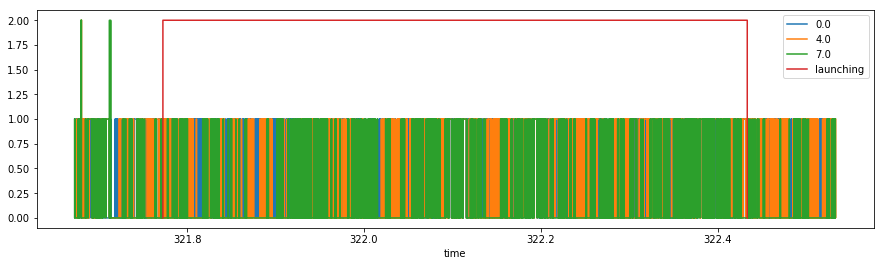

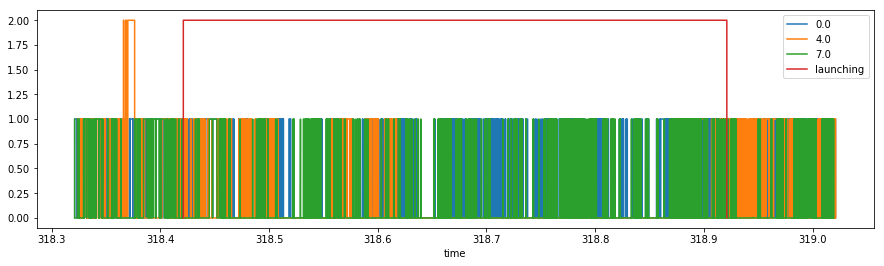

In [40]:
print(group1.title)
DrawCorrectedData(group1, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

0EBF5_0FBF5TA2_QOS_200117_200117_181416_note


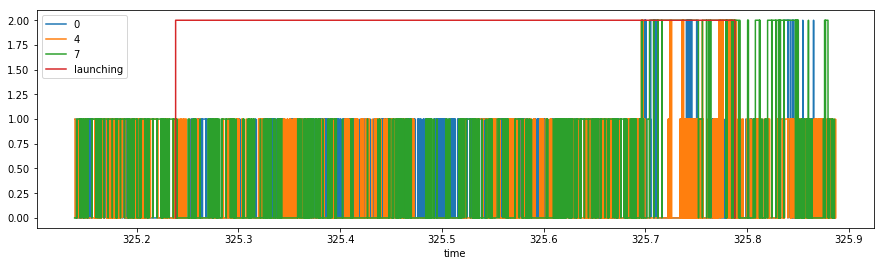

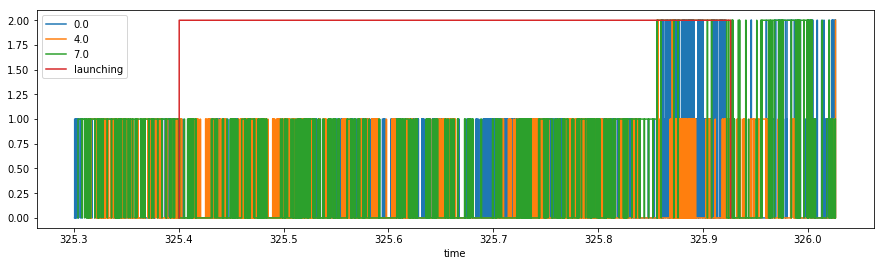

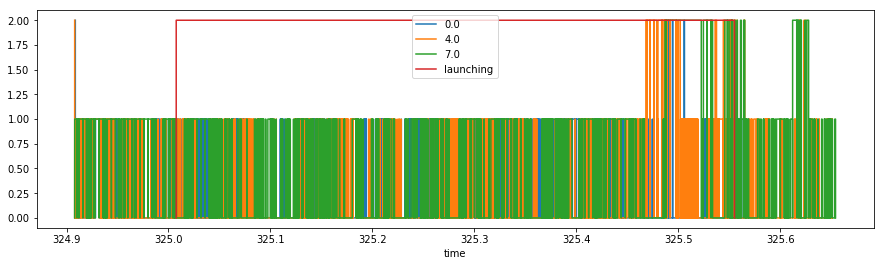

In [41]:
print(group2.title)
DrawCorrectedData(group2, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

### Lock Contention

In [42]:
df1 = group1.get(['lock_contention']) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(['lock_contention']) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [43]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
#display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
0EBF5_0EBF5TC3_QOS_200304_200304_135427_note,lock_contention,0,54.983,0.347,6.188,7.778,8.929,3.793,0
0EBF5_0FBF5TA2_QOS_200117_200117_181416_note,lock_contention,0,9.000,0.000,6.581,9.791,4.991,7.089,0
DIFF,lock_contention,0,45.983,0.347,-0.393,-2.013,3.938,-3.296,0


In [44]:
def DrawLockContention(parser):
    for lock_contention in parser.storage_lock_contention:
        lock_contention['owner'] = lock_contention['context'].split('owner ')[1].split(' waiters')[0]
        lock_contention['blocking'] = lock_contention['context'].split('blocking from')[1]
    df = DataFrame.from_dict(parser.storage_lock_contention)
    df.loc[df['duration'] > 0, 'duration'] *= 1000

    return df
        #if value == 'NaN':
            
        #else:
        #    display(DataFrame(df[value].value_counts()))

Liminated the lock contentions by the main thread is sleepping in an app.
(The effection means that lock contentions seem to effect to the app entry because the process stat was sleep.)

In [45]:
#for parser in group.parsers_of_testing:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df1 = df[df['effection'] == 'O']
display(group1.title)
display(df1.sort_values(by=['duration'], ascending=False))

u'0EBF5_0EBF5TC3_QOS_200304_200304_135427_note'

,blocking,context,duration,effection,owner,pid,time,type
19,boolean com.android.server.wm.ActivityTaskMan...,monitor contention with owner Binder:1233_E (3...,28.213,O,Binder:1233_E (3004) at void com.android.serve...,1259,317.577040,B
20,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1233_E (3...,27.992,O,Binder:1233_E (3004) at void com.android.serve...,1525,317.577344,B
21,com.android.server.policy.WindowManagerPolicy...,monitor contention with owner Binder:1233_E (3...,27.747,O,Binder:1233_E (3004) at void com.android.serve...,1260,317.577603,B
27,android.app.ContentProviderHolder com.android...,monitor contention with owner android.display ...,19.771,O,android.display (1259) at java.util.List com.a...,3074,317.589457,B
93,void com.android.server.wm.ActivityTaskManage...,monitor contention with owner Binder:1233_E (3...,17.095,O,Binder:1233_E (3004) at void com.android.serve...,1259,317.966220,B
58,boolean com.android.server.wm.WindowProcessCo...,monitor contention with owner android.ui (1257...,9.383,O,android.ui (1257) at java.util.List com.androi...,3074,317.643259,B
59,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (12...,8.646,O,android.anim (1260) at int com.android.server....,1259,317.644095,B
60,boolean com.android.server.wm.ActivityTaskMan...,monitor contention with owner android.anim (12...,7.434,O,android.anim (1260) at int com.android.server....,1257,317.645489,B
111,void com.android.server.wm.WindowAnimator.lam...,monitor contention with owner Binder:1233_E (3...,7.352,O,Binder:1233_E (3004) at int com.android.server...,1260,318.010257,B
74,android.app.ContentProviderHolder com.android...,monitor contention with owner android.display ...,6.552,O,android.display (1259) at void com.android.ser...,1423,317.708118,B


In [46]:
#for parser in group.parsers_of_testing:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df2 = df[df['effection'] == 'O']
display(group2.title)
display(df2.sort_values(by=['duration'], ascending=False))

u'0EBF5_0FBF5TA2_QOS_200117_200117_181416_note'

,blocking,context,duration,effection,owner,pid,time,type
10,android.app.ContentProviderHolder com.android...,monitor contention with owner android.display ...,24.119,O,android.display (5027) at void com.android.ser...,5201,325.250816,B
11,android.app.ActivityManager$StackInfo com.and...,monitor contention with owner Binder:4970_11 (...,22.647,O,Binder:4970_11 (6823) at void com.android.serv...,5027,325.251284,B
12,float com.android.server.wm.WindowManagerServ...,monitor contention with owner Binder:4970_11 (...,15.153,O,Binder:4970_11 (6823) at void com.android.serv...,5029,325.258959,B
15,android.content.Intent com.android.server.am....,monitor contention with owner android.display ...,14.184,O,android.display (5027) at void com.android.ser...,5598,325.263865,B
103,void com.android.server.wm.ActivityTaskManage...,monitor contention with owner Binder:4970_2 (4...,9.567,O,Binder:4970_2 (4987) at void com.android.serve...,5027,325.587762,B
104,float com.android.server.wm.WindowManagerServ...,monitor contention with owner Binder:4970_2 (4...,7.783,O,Binder:4970_2 (4987) at void com.android.serve...,5201,325.590122,B
81,void com.android.server.wm.TaskChangeNotifica...,monitor contention with owner Binder:4970_2 (4...,6.007,O,Binder:4970_2 (4987) at int com.android.server...,5027,325.372169,B
61,boolean com.android.server.am.ActivityManager...,monitor contention with owner android.display ...,5.778,O,android.display (5027) at void com.android.ser...,4987,325.329004,B
35,void com.android.server.am.ActivityManagerSer...,monitor contention with owner android.display ...,5.147,O,android.display (5027) at void com.android.ser...,4987,325.290075,B
117,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:4970_2 (4...,4.915,O,Binder:4970_2 (4987) at int com.android.server...,5027,325.657719,B


In [47]:
display(group1.title)
display(df1['duration'].sum())

u'0EBF5_0EBF5TC3_QOS_200304_200304_135427_note'

267.7140000001259

In [48]:
display(group2.title)
display(df2['duration'].sum())

u'0EBF5_0FBF5TA2_QOS_200117_200117_181416_note'

192.17700000018567

Sum of the lock contention's duration. The durations could be duplicated.

Liminated the lock contentions by owners.

In [49]:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group1.title)
display(DataFrame(df['owner'].value_counts()))

u'0EBF5_0EBF5TC3_QOS_200304_200304_135427_note'

,owner
"FreecessHandler (2480) at void com.android.server.am.freecess.FreecessController.triggerOLAF(java.lang.String, int)(FreecessController.java:1559)",12
android.anim (1260) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:145),7
"AsyncTask #1 (13014) at void android.content.res.AssetManager.applyStyle(long, int, int, android.content.res.XmlBlock$Parser, int[], long, long)(AssetManager.java:1113)",7
android.anim (1260) at void com.android.server.wm.InputMonitor$1.run()(InputMonitor.java:126),6
"Binder:1233_4 (1525) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2302)",6
"android.ui (1257) at java.util.List com.android.server.wm.ActivityTaskManagerService.getFilteredTasks(int, int, int)(ActivityTaskManagerService.java:3400)",4
android.display (1259) at void com.android.server.wm.WindowManagerService$H.handleMessage(android.os.Message)(WindowManagerService.java:5543),4
Binder:1233_E (3004) at void com.android.server.wm.ActivityTaskManagerService.activityPaused(android.os.IBinder)(ActivityTaskManagerService.java:2449),3
Binder:1233_E (3004) at void com.android.server.wm.RemoteAnimationController.onAnimationFinished()(RemoteAnimationController.java:281),2
"Binder:1233_E (3004) at int com.android.server.wm.WindowManagerService.addWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.view.InputChannel, android.view.InsetsState)(WindowManagerService.java:1425)",2


In [50]:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group2.title)
display(DataFrame(df['owner'].value_counts()))

u'0EBF5_0FBF5TA2_QOS_200117_200117_181416_note'

,owner
"AsyncTask #1 (17163) at void android.content.res.AssetManager.applyStyle(long, int, int, android.content.res.XmlBlock$Parser, int[], long, long)(AssetManager.java:1113)",10
android.anim (5029) at void com.android.server.wm.InputMonitor$1.run()(InputMonitor.java:126),8
"FreecessHandler (6215) at void com.android.server.am.freecess.FreecessController.triggerOLAF(java.lang.String, int)(FreecessController.java:1522)",8
android.anim (5029) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:141),6
"main (17109) at boolean android.content.res.AssetManager.getResourceValue(int, int, android.util.TypedValue, boolean)(AssetManager.java:555)",4
"Binder:4970_2 (4987) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2249)",4
"android.display (5027) at void com.android.server.am.ActivityManagerService$LocalService.updateActivityUsageStatsWithIntent(android.content.ComponentName, int, int, android.os.IBinder, android.content.ComponentName, android.content.Intent)(ActivityManagerService.java:20528)",3
"android.ui (5019) at android.os.Message com.android.internal.util.function.pooled.PooledLambda.obtainMessage(java.util.function.BiConsumer, java.lang.Object, java.lang.Object)(PooledLambda.java:442)",3
Binder:4970_C (5617) at android.content.pm.UserInfo com.android.server.pm.UserManagerService.getUserInfo(int)(UserManagerService.java:1261),3
Binder:4970_2 (4987) at void com.android.server.wm.RemoteAnimationController.onAnimationFinished()(RemoteAnimationController.java:281),3


Text(0,0.5,'weight')

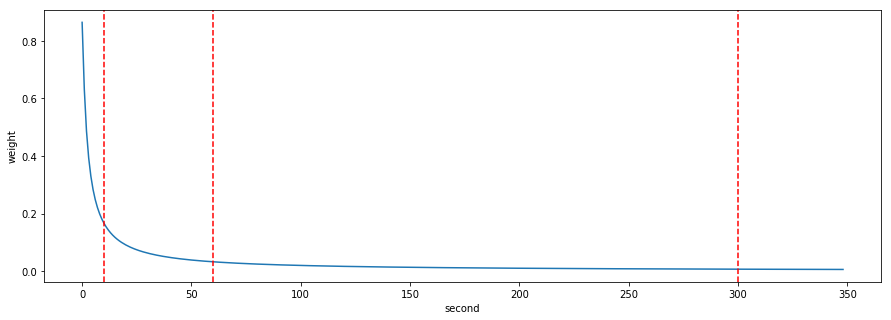

In [51]:
from math import exp


#display(np.exp(-2.0/np.arange(1,300.0)) * 2048)
plt.figure(figsize=(15,5))
plt.plot(1 - np.exp(-2.0/np.arange(1,350.0)))
plt.axvline(x=10, color='r', linestyle='--')
plt.axvline(x=60, color='r', linestyle='--')
plt.axvline(x=300, color='r', linestyle='--')
plt.xlabel('second')
plt.ylabel('weight')